In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

listings = pd.read_csv('listings.csv')

# Section 1: Initial Data Integrity Check and Cleaning

In [2]:
# The dataset is comprised of 8078 rows and 106 columns.

print('Rows: ', len(listings),'\n'
     'Columns: ', len(listings.columns))

Rows:  8078 
Columns:  106


In [3]:
# With 106 colulmns, it was easiest to manually review and decide what I wanted to remove.

dropCols = ['listing_url','scrape_id','last_scraped','summary','space','neighborhood_overview','notes'
            , 'access','thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_name'
            , 'host_about','host_thumbnail_url','host_picture_url','host_listings_count','neighbourhood'
            , 'calendar_last_scraped','neighbourhood_group_cleansed','city','state','market','smart_location'
            ,'country_code','country','name', 'description','house_rules']

for x in dropCols:
    del listings[x]

In [4]:
# Checking for incomplete data
# There are 28 columns containing null values. 
# Our quartiles show that the average is being dragged up by outliers, which can be seen in the chart below.

incompleteDataResults = []
for i in listings.columns:
    if listings[i].isnull().sum() > 0:
        incompleteDataResults.append((i, listings[i].isnull().sum()))
        
cols = ['columnName', 'countNull']
incompleteDF=(pd.DataFrame(incompleteDataResults, columns = cols))
print(incompleteDF.describe())

         countNull
count    28.000000
mean   2039.571429
std    2107.937827
min       4.000000
25%     642.250000
50%    1901.000000
75%    1965.000000
max    7968.000000


In [5]:
# format date cols

dates = ['host_since', 'first_review', 'last_review']
for x in dates:
    listings[x] = pd.to_datetime(listings[x], format= '%Y-%m-%d')
    
# format percentage cols.

percentages = ['host_response_rate', 'host_acceptance_rate']
for x in percentages:
    listings[x] = pd.to_numeric(listings[x].str.strip('%')).div(100)
    listings[x] = listings[x].astype(float)
    
# format currency cols
currency = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee'
         , 'guests_included','extra_people']
for x in currency:
    listings[x] = listings[x].replace('[\$,]', '', regex=True).astype(float)
    
# format numeric cols
numerics = ['host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds'
          , 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights'
          , 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'
          , 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews'
          , 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness'
          , 'review_scores_checkin', 'review_scores_communication', 'review_scores_location','review_scores_value'
          , 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes'
          , 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'
          , 'reviews_per_month']
for x in numerics:
    listings[x] = listings[x].astype(float)

# format booleans
# for x in bools:
listings = listings.replace(['t', 'f'], [1,0]) 

In [6]:
# check to make sure dates are correct. There are no records where the first review is greater than the last review.

[listings[listings['first_review'].isnull()==False] > listings[listings['last_review'].isnull()==False]] == True

False

In [7]:
# Airbnb was founded in August 2008. Two records are before August 2008, so they will be removed.

print('Records before August 2008: ', listings[listings['host_since']<'2008-08-01']['id'].count())
listings = listings[listings['host_since']>'2008-08-01']

Records before August 2008:  2


In [8]:
# when manually taking a look at the data, street did not seem to pass through correctly. We can still make sure 
# that all residences are in SF.
# remove all data not in SF
# South SF will sneak through based on the above logic. We will filter out South SF in particular

listings = listings[listings['street'].str.contains('San Francisco')]
listings = listings[~listings['street'].str.contains('South San Francisco')]

In [9]:
# some guests have never updated their calendar. This likely means they signed up to host, but never accepted a 
# reservation. we can remove them from the dataset

listings = listings[~listings['calendar_updated'].str.contains('never')]

In [10]:
# make sure listings are unique

listings['id'].nunique() / len(listings)

1.0

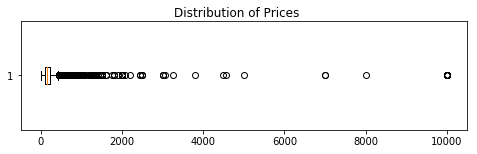

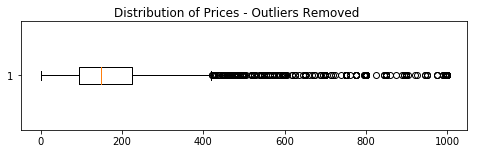

In [11]:
# there are a few outliers in regards to price per night. removing rentals over $1k per night

plt.rcParams['figure.figsize'] = 8,2
plt.figure().suptitle('Distribution of Prices')
plt.boxplot(listings['price'], vert=False)
plt.show()

listings = listings[listings['price']<1000.0]

plt.figure().suptitle('Distribution of Prices - Outliers Removed')
plt.boxplot(listings['price'], vert=False)
plt.show()

# Section 2: Data Exploration

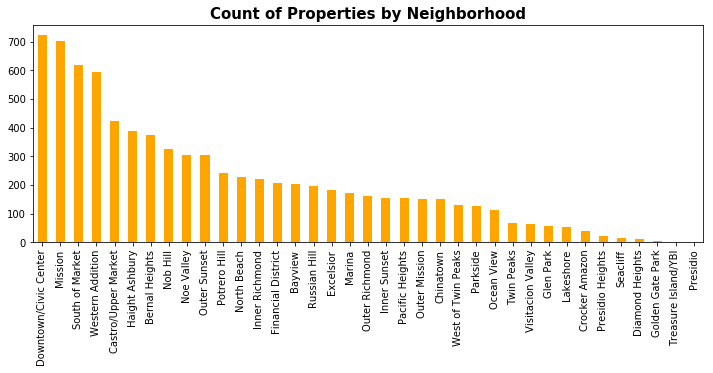

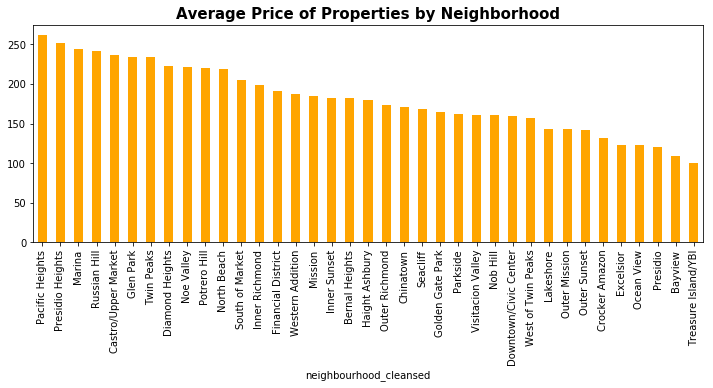

In [12]:
# count the records by neighborhood as well as avg. price by neighborhood

plt.rcParams['figure.figsize'] = 12,4
listings['neighbourhood_cleansed'].value_counts().plot(kind='bar', color='orange')
plt.title('Count of Properties by Neighborhood', fontsize=15,fontweight='bold')
plt.show()

hoods__avg_price = listings.groupby(['neighbourhood_cleansed'], as_index=False).mean()
hoods__avg_price = hoods__avg_price[['neighbourhood_cleansed', 'price']].sort_values(by='price', ascending=False) 
hoods__avg_price.plot(x='neighbourhood_cleansed', y='price', kind='bar', legend=False, color='orange')
plt.title('Average Price of Properties by Neighborhood', fontsize=15, fontweight='bold')
plt.show()

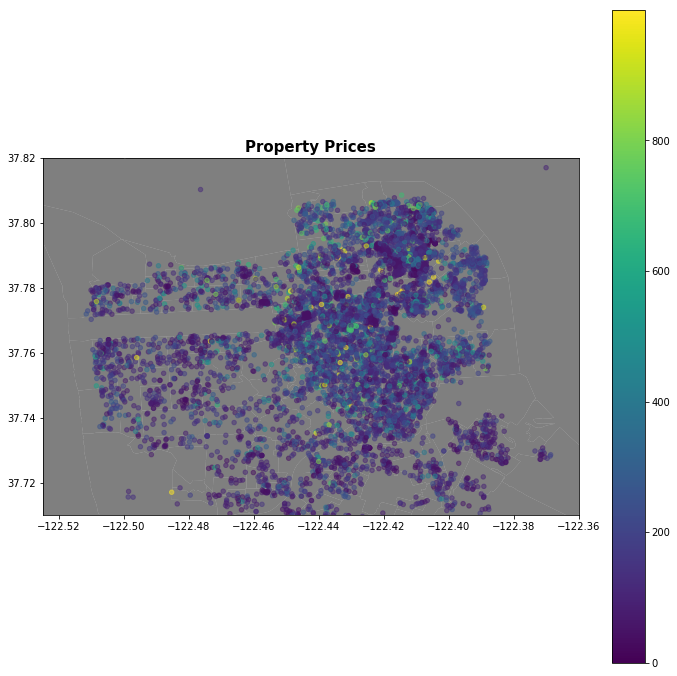

In [13]:
# map of prices by listing

street_map = gpd.read_file('./geo_data/geo_export_6619bdbe-44d0-4fc6-b76f-276d186956e9.shp')

crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(listings['longitude'], listings['latitude'])]
geo_df = gpd.GeoDataFrame(listings,crs = crs, geometry = geometry)
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.5, color='black')
geo_df.plot(column='price', ax=ax,alpha=0.5, legend=True, markersize=20)
plt.title('Property Prices', fontsize=15,fontweight='bold')
plt.xlim(-122.525, -122.36)
plt.ylim( 37.71, 37.82)
plt.show()

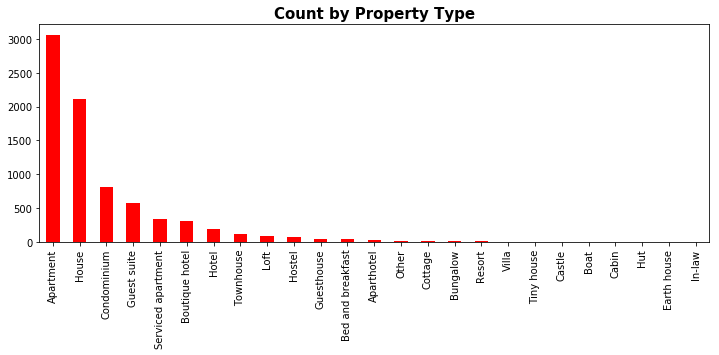

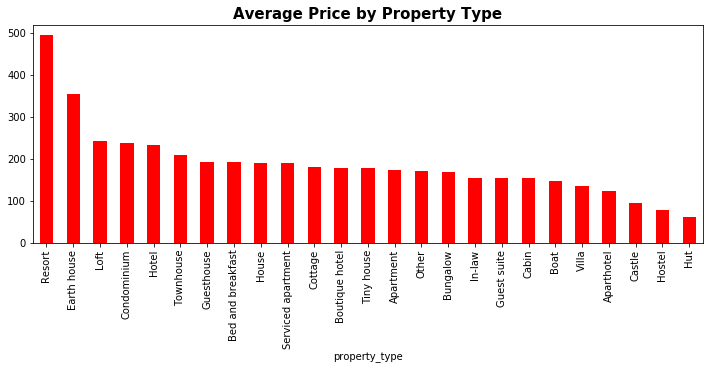

In [14]:
# record count and avg. price by property type.

listings['property_type'].value_counts().plot(kind='bar', color='red')
plt.title('Count by Property Type', fontsize=15,fontweight='bold')
plt.show()

plt.rcParams['figure.figsize'] = 12,4
propTypeAvgPrice = listings.groupby(['property_type'], as_index=False).mean()
propTypeAvgPrice = propTypeAvgPrice[['property_type', 'price']].sort_values(by='price', ascending=False) 
propTypeAvgPrice.plot(x='property_type', y='price', kind='bar', legend=False, color='red')
plt.title('Average Price by Property Type', fontsize=15, fontweight='bold')
plt.show()

# Section 3: Feature Engineering / Data Prep

In [36]:
# create a working dataset with features that will impact pricing

workingData = listings[['transit', 'host_response_time', 'host_response_rate'
                                , 'host_acceptance_rate' , 'host_is_superhost', 'host_has_profile_pic'
                                , 'host_identity_verified' , 'neighbourhood_cleansed', 'zipcode'
                                , 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms'
                                , 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'minimum_nights'
                                , 'maximum_nights', 'calendar_updated', 'number_of_reviews'
                                ,'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness'
                                , 'review_scores_checkin', 'review_scores_communication', 'review_scores_location'
                                , 'review_scores_value', 'requires_license', 'instant_bookable'
                                , 'is_business_travel_ready', 'cancellation_policy', 'require_guest_profile_picture'
                                , 'require_guest_phone_verification', 'reviews_per_month', 'price']]

In [37]:
# transformations on popular SF transit types

transportationTypes = ['bart', 'muni', 'train', 'bus']

for i in transportationTypes:
    workingData[i] = workingData['transit'].str.lower().str.contains(i)
    workingData[i].fillna(False, inplace=True)
    workingData[i].replace([True, False], [1,0], inplace=True)

del workingData['transit']

# transform response times
responseTimes = ['within a few hours', 'within an hour', 'within a day', 'a few days or more']

for i in responseTimes:
    workingData['response_time_'+i] = workingData['host_response_time'].str.lower().str.contains(i)
    workingData['response_time_'+i].fillna(False, inplace=True)
    workingData['response_time_'+i].replace([True, False], [1,0], inplace=True)
    
del workingData['host_response_time']

In [38]:
# clean zip code

workingData['zipcode'] = workingData['zipcode'].str[-5:]
workingData = workingData[workingData['zipcode']!='CA']
workingData = workingData.dropna(subset=['zipcode'])

In [39]:
# imputing null values with the median
nullCols = workingData.columns[workingData.isna().any()].tolist()

for i in nullCols:
    workingData[i].fillna((workingData[i].median()), inplace=True)

In [40]:
# identify non-numeric columns as we will need to transform them to numeric for sklearn

categorical = workingData.columns[(workingData.dtypes.values == np.dtype('float64'))]
objects = workingData.columns[(workingData.dtypes.values == np.dtype('object'))]

le = LabelEncoder()
for i in categorical:
    le.fit(workingData[i])
    workingData[i] = le.transform(workingData[i])
    
for i in objects:
    le.fit(workingData[i])
    workingData[i] = le.transform(workingData[i])

In [41]:
workingData.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'zipcode', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'square_feet', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'reviews_per_month', 'price', 'bart', 'muni', 'train', 'bus',
       'response_time_within a few hours', 'response_time_within an hour',
       'response_time_within a day', 'response_time_a few

# Section 4: Predicting Price

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [43]:
# split the data for training and testing

cols = workingData.columns
cols = cols.drop(['price'])

X = workingData[cols]
y = workingData['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [44]:
# create a list of applicable models and evaluate their initial performance based on RMSE and R2

mod = []
lr = LinearRegression()
mod.append(lr)
lasso = linear_model.Lasso()
mod.append(lasso)
bay = linear_model.BayesianRidge()
mod.append(bay)
forest_reg = RandomForestRegressor()
mod.append(forest_reg)
grad_boost = GradientBoostingRegressor()
mod.append(grad_boost)

model_names = ['LinearRegression', 'Lasso', 'BayesianRidge', 'RandomForestRegressor', 'GradientBoostingRegressor']
rmse = []
r2 = []

for i in mod:
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    model_mse = mean_squared_error(pred, y_test)
    rmse.append(np.sqrt(model_mse))
    r2.append(i.score(X_test, y_test))
    
model_scores = pd.DataFrame(columns={'Model', 'R2', 'RMSE'})
model_scores['Model'] = model_names
model_scores['R2'] = r2
model_scores['RMSE'] = rmse

model_scores.sort_values(by=['R2', 'RMSE'], ascending=False)

,RMSE,Model,R2
3,60.282498,RandomForestRegressor,0.637193
4,60.620243,GradientBoostingRegressor,0.633116
0,66.366612,LinearRegression,0.560263
2,66.463013,BayesianRidge,0.558985
1,66.809902,Lasso,0.554369


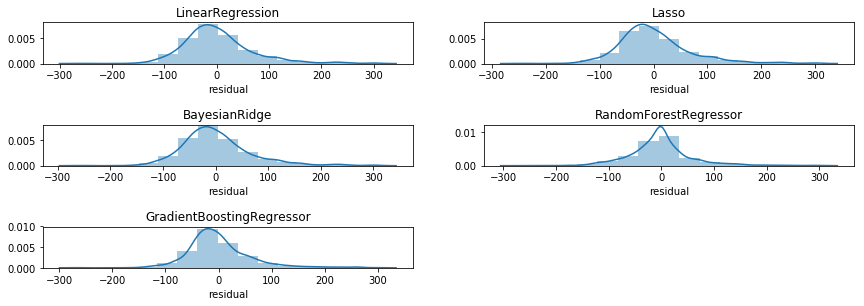

In [45]:
#  Visualizing the results

model_names_df = [i + '_df' for i in model_names]

for x in range(0,5):
    z = mod[x].predict(X_test)
    model_names_df[x] = pd.DataFrame( { 'actual': y_test,
                                    'predicted': np.round( z, 2),
                                    'residual': y_test - z } )
    
model_names = ['LinearRegression', 'Lasso', 'BayesianRidge', 'RandomForestRegressor', 'GradientBoostingRegressor']
    
f, ax = plt.subplots(3,2)
f.tight_layout(h_pad=4, w_pad=4)

a = sns.distplot(model_names_df[0]['residual'], bins=15, ax=ax[0,0]).set_title(model_names[0])
b = sns.distplot(model_names_df[1]['residual'], bins=15, ax=ax[0,1]).set_title(model_names[1])
c = sns.distplot(model_names_df[2]['residual'], bins=15, ax=ax[1,0]).set_title(model_names[2])
d = sns.distplot(model_names_df[3]['residual'], bins=15, ax=ax[1,1]).set_title(model_names[3])
e = sns.distplot(model_names_df[4]['residual'], bins=15, ax=ax[2,0]).set_title(model_names[4])
f.delaxes(ax.flatten()[5])
plt.show()

In [59]:
#  choose top performing model and add tuning parameters

forest_reg = RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features='sqrt', warm_start=True)
forest_reg.fit(X_train, y_train)
print ('R2: ', forest_reg.score(X_test, y_test))

R2:  0.6822384802757131
